In [75]:
#%matplotlib widget
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [15, 6]
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sklearn

from scipy import stats

## Clustering of URIEL VECTORS

Functions that we're going to need:

In [76]:
##################################################################################
def sample_treebanks(original, seed, mode): #Input: A dataframe with  UD treebanks (columns: target treebank rows: transfer treebank), 
                                                #A random seed
                                            #Ouput: A list with a sample of treebanks (one per language)
    UDs= defaultdict(list)
    if mode =="columns":
        treebanks=original.columns
    else:
        treebanks=original.index
    
    for col in treebanks:  #All languages treebanks (columns)
        tmplist=[]
        x = col.split("UD_")[1].split("-")
        languagename=x[0] #Language Name
        #print (languagename, col)
        tmplist.append(col)
        #Create a Dictionary languagename:(treebank1, treebank2, ...)
        if languagename not in UDs:
            UDs[languagename]=tmplist
        else:
            UDs[languagename].append(col)
    #UDs contains each languagename and the associated treebanks
    
    ####Random sampling:#####
    random.seed(a=seed)

    #Foreach key (language name) randomly select just one treebank:  if array greater than 1, sample, assign to new dict
    UDs_sampled= defaultdict(list)  #UDs_sampled contains each languagename and the randomly selected treebank
    for key, value in UDs.items() :
        if len(value)>1: #only for Languages with more than one UD
            #print (key, value)
            randomtreebank=random.choice(value)
            UDs_sampled[key]=randomtreebank
        else:
            UDs_sampled[key]=value[0] #Languages with only one treebank, remain the same. 

    #print(UDs_sampled)

    sample=list(UDs_sampled.values())  #The random sample
    return sample

---
- Preparing URIEL vectors:

In [77]:
l2v = pd.read_csv("../data/l2v.csv",index_col=0)  #l2v vectors
iso = pd.read_csv("../data/iso.csv", index_col=0)  #iso csv:  UD, iso code

- Sampling just one treebank per language:

In [78]:
#No repetitions:
randomsample=sample_treebanks(l2v, 1, "rows")
l2v=l2v.loc[l2v.index.intersection(randomsample)]
#Drop Armenian since in l2v is the same vector associated with two UDs:
l2v=l2v.drop(["UD_Armenian-ArmTDP"])
iso=iso.loc[iso.index.intersection(l2v.index)]  #set of UDs that we use in our experiments
l2v

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
Treebank,,,,,,,,,,,,,,,,,,,,,
UD_Afrikaans-AfriBooms,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
UD_Ancient_Greek-PROIEL,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
UD_Arabic-PADT,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
UD_Basque-BDT,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
UD_Belarusian-HSE,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UD_Uyghur-UDT,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
UD_Vietnamese-VTB,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
UD_Welsh-CCG,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0



- Apply PCA:

In [79]:

#mpl.style.use("default")

#We apply PCA to L2V (URIEL) vectors:
pca=PCA(n_components=2)
pca.fit(l2v)
pca_data=pca.transform(l2v)

results_pca = pd.DataFrame(pca_data)
results_pca.rename(columns={ 0 : 'x', 1 : 'y'}, inplace=True)
#################################



- Clustering of URIEL vectors:

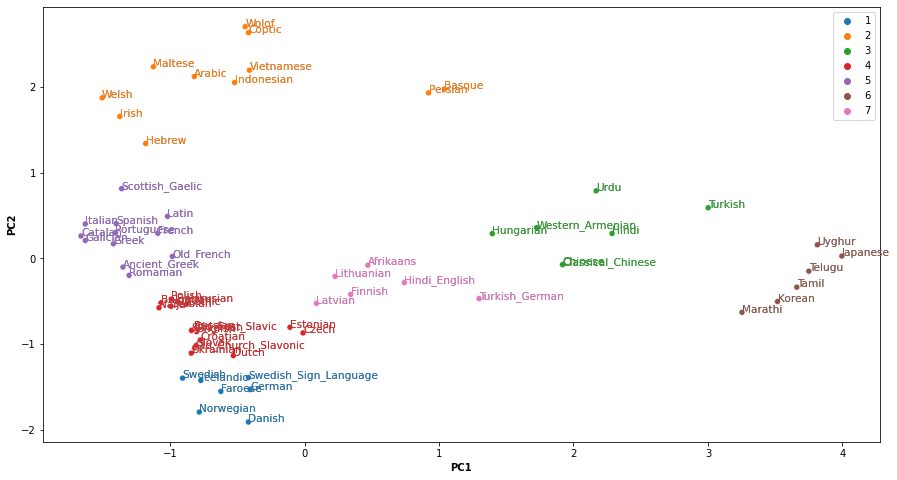

In [80]:
caption="normal"
dataset=results_pca
clusters=7
#Center and scaling:
trans = StandardScaler()
data = trans.fit_transform(dataset)
#data=dataset
##################Kclustering:#######################################3

km = sklearn.cluster.KMeans(n_clusters=clusters, random_state=19, init='k-means++', algorithm="full")
km.fit(data)

# Get cluster assignment labels
labels = km.labels_

# Format results as a DataFrame
results = pd.DataFrame([dataset.index,labels]).T  

    #Join the clustering with the info for each language
    #clustered=pd.concat([dataset, results],  axis=1)

results=results.rename(columns={1: "cluster", 0:"file"})
#results=results.set_index("file")
results.insert(0, 'TargetLanguage', l2v.index)
results=results.set_index("TargetLanguage")
results=results.drop(columns=['file'])
#results=pd.concat([results, l2vvslas,  bpevslas, mwlvslas, mslvslas, deprelvslas, structvslas],  axis=1)

#results.to_csv("features"+caption+"clustering_k"+str(clusters)+".csv", index=True,)



##############Plotting######

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

xs = results_pca['x']
ys = results_pca['y']
#zs = results_pca['z']
colors=results["cluster"].tolist()
labels=l2v.index
labels_filtered = [w.replace('UD_', '') for w in labels] #only language and UD
labels_filtered2 = [w.split("-")[0] for w in labels_filtered] #only language

ax.set_xlabel('x',fontdict=dict(weight='bold'))
ax.set_ylabel('y',fontdict=dict(weight='bold'))
#ax.set_zlabel('z',fontdict=dict(weight='bold'))

#plt.zlim([-3, 3])
#img=ax.scatter(xs, ys, s=50, alpha=0.6, edgecolors='w', c=colors,cmap='rainbow' )

#For starting the clustering at 1 in the labels:
colors_tmp = [1 + direction for direction in colors]

sns.scatterplot(x="x", y="y", hue=colors_tmp,
                data=results_pca, palette=sns.color_palette("tab10",7))

ax.set_xlabel('PC1',fontdict=dict(weight='bold'))
ax.set_ylabel('PC2',fontdict=dict(weight='bold'))

for x, y, label, color in zip(xs, ys, labels_filtered2, colors_tmp):
    ax.text(x, y,  label, weight="book", color="gray", fontsize=10.5)
    
    if (color==1):
        ax.text(x, y,  label, weight="book", color="#1f77b4", fontsize=10.5)
    if (color==2):
        ax.text(x, y,  label, weight="book", color="#ff7f0e", fontsize=10.5)
    if (color==3):
        ax.text(x, y,  label, weight="book", color="#2ca02c", fontsize=10.5)
        
    if (color==4):
        ax.text(x, y,  label, weight="book", color="#d62728", fontsize=10.5)
        
    if (color==5):
        ax.text(x, y,  label, weight="book", color="#9467bd", fontsize=10.5)
        
    if (color==6):
        ax.text(x, y,  label, weight="book", color="#8c564b", fontsize=10.5)
        
    if (color==7):
        ax.text(x, y,  label, weight="book", color="#e377c2", fontsize=10.5)



## Correlations within clusters

In [81]:
def assign_nans(df1):# Input: a dataframe
                     #Output: a dataframe with NaNs values instead of the score when the trasnfer and target are the same UD
#if col=row put a Nan
    for col in df1.columns:
        for row in df1[col].index:
            if col==row:
                #print(col, row, df1.loc[row, col])
                df1.loc[row, col]=np.NaN
    return(df1)

def sample_treebanks_modified(treebanks, seed, mode): #Input: A dataframe with  UD treebanks (columns: target treebank rows: transfer treebank), 
                                                #A random seed
                                            #Ouput: A list with a sample of treebanks (one per language)
    UDs= defaultdict(list)
    if mode =="columns":  #choose some different random sample for coklumns and rows
        seed=seed+1
    #else:
    #    treebanks=original.index
    
    for col in treebanks:  #All languages treebanks (columns)
        tmplist=[]
        x = col.split("UD_")[1].split("-")
        languagename=x[0] #Language Name
        #print (languagename, col)
        tmplist.append(col)
        #Create a Dictionary languagename:(treebank1, treebank2, ...)
        if languagename not in UDs:
            UDs[languagename]=tmplist
        else:
            UDs[languagename].append(col)
    #UDs contains each languagename and the associated treebanks
    
    ####Random sampling:#####
    random.seed(a=seed)

    #Foreach key (language name) randomly select just one treebank:  if array greater than 1, sample, assign to new dict
    UDs_sampled= defaultdict(list)  #UDs_sampled contains each languagename and the randomly selected treebank
    for key, value in UDs.items() :
        if len(value)>1: #only for Languages with more than one UD
            #print (key, value)
            randomtreebank=random.choice(value)
            UDs_sampled[key]=randomtreebank
        else:
            UDs_sampled[key]=value[0] #Languages with only one treebank, remain the same. 

    #print(len(UDs_sampled))

    sample=list(UDs_sampled.values())  #The random sample
    return sample

In [83]:
las_path="../data/las_distances.tsv"
bpe_path="../data/bpe_distances.tsv"
deprel_path="../data/deprel_distances.tsv"
struct_path="../data/struct_distances.tsv"
mwl_path="../data/mwl_distances.tsv"
msl_path="../data/msl_distances.tsv"
l2v_path="../data/l2v_distances.tsv"

bpe_distances = pd.read_csv(bpe_path,index_col=0, sep="\t")
las_distances = pd.read_csv(las_path,index_col=0, sep="\t")
mwl_distances = pd.read_csv(mwl_path,index_col=0, sep="\t")
msl_distances = pd.read_csv(msl_path,index_col=0, sep="\t")
l2v_distances = pd.read_csv(l2v_path,index_col=0, sep="\t")
deprel_distances = pd.read_csv(deprel_path,index_col=0, sep="\t")
struct_distances = pd.read_csv(struct_path,index_col=0, sep="\t")

assign_nans(las_distances)
assign_nans(bpe_distances)
assign_nans(mwl_distances)
assign_nans(msl_distances)
assign_nans(l2v_distances)
assign_nans(deprel_distances)
assign_nans(struct_distances)

,UD_Afrikaans-AfriBooms,UD_Ancient_Greek-PROIEL,UD_Ancient_Greek-Perseus,UD_Arabic-PADT,UD_Armenian-ArmTDP,UD_Basque-BDT,UD_Belarusian-HSE,UD_Bulgarian-BTB,UD_Catalan-AnCora,UD_Chinese-GSD,...,UD_Turkish-Penn,UD_Turkish-Tourism,UD_Turkish_German-SAGT,UD_Ukrainian-IU,UD_Urdu-UDTB,UD_Uyghur-UDT,UD_Vietnamese-VTB,UD_Welsh-CCG,UD_Western_Armenian-ArmTDP,UD_Wolof-WTB
UD_Ancient_Greek-PROIEL,65.351566,NaN,59.398535,65.683882,64.543696,65.420321,65.626586,65.414591,65.076546,65.448969,...,65.712530,65.420321,64.113977,64.686935,65.191138,64.532236,64.755690,64.262946,64.583803,64.388997
UD_Ancient_Greek-Perseus,65.678152,59.398535,NaN,65.827121,64.784338,65.557831,65.832851,65.391673,65.580749,65.930253,...,65.907335,66.159437,64.578073,65.122383,65.385944,64.732772,65.024980,64.669746,64.583803,64.681205
UD_Arabic-PADT,63.856146,65.683882,65.827121,NaN,64.268676,64.629639,65.511994,64.526507,63.953549,64.028034,...,65.678152,67.190761,65.368755,64.033763,64.050952,66.990225,63.901983,64.589532,64.606721,65.523453
UD_Basque-BDT,63.804580,65.420321,65.557831,64.629639,63.306107,NaN,64.790067,63.695718,63.351943,63.294648,...,63.879065,66.766772,64.635369,63.403510,63.225893,66.451645,63.753014,64.131166,63.283188,64.893200
UD_Belarusian-HSE,64.675476,65.626586,65.832851,65.511994,64.205651,64.790067,NaN,61.942467,62.670124,64.165543,...,64.578073,67.202220,65.872958,61.300755,65.168220,67.672045,64.841634,65.242704,64.537966,66.136518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UD_Turkish-Penn,65.248434,65.712530,65.907335,65.678152,64.641098,63.879065,64.578073,64.635369,64.595262,64.091059,...,NaN,66.921470,65.718259,64.285865,64.234298,67.190761,65.185408,66.016197,64.641098,66.256839
UD_Turkish-Tourism,67.030332,65.420321,66.159437,67.190761,65.305729,66.766772,67.202220,67.064710,67.190761,66.915741,...,66.921470,NaN,62.200298,66.915741,66.222462,60.384022,64.870282,62.750338,65.208327,62.922225
UD_Ukrainian-IU,62.882118,64.686935,65.122383,64.033763,62.647205,63.403510,61.300755,61.042923,61.214811,62.584180,...,64.285865,66.915741,64.950496,NaN,63.758743,67.414214,63.615504,64.148355,62.761797,65.334377
UD_Urdu-UDTB,63.323296,65.191138,65.385944,64.050952,62.566991,63.225893,65.168220,64.320242,63.781662,62.927955,...,64.234298,66.222462,64.131166,63.758743,NaN,66.016197,63.420698,63.913442,62.566991,64.606721


In [85]:


all_languages=l2v_distances.columns.tolist()
for k in range(clusters):
    deprel_means= [] 
    struct_means= []
    bpe_means= []
    msl_means= []
    mwl_means= []
    l2v_means= []
    #filter dataframe for each cluster
    filteredbycluster= pd.DataFrame(results.loc[(results['cluster']==k)])
    languagesbycluster=filteredbycluster.index.tolist()  #['UD_Hindi-HDTB', 'UD_Turkish_German-SAGT', 'UD_Urdu-UDTB', 'UD_Western_Armenian-ArmTDP']
    #print(languagesbycluster)
    #remove suffix:
    tmp=[]
    for l in languagesbycluster:
        #print(l)
        prefix=l.split("-")[0] #['UD_Hindi', 'UD_Turkish_German', 'UD_Urdu', 'UD_Western_Armenian']
        #print(prefix)
        #Expand the prefixes to the several UDS by it using the original rows names:  
        result = [i for i in all_languages if i.startswith(prefix)]  #['UD_Hindi-HDTB', 'UD_Hindi_English-HIENCS']
        tmp.append(result)
    languagesbycluster=[x for xs in tmp for x in xs] #flattened list with list of "expanded" UDS: ['UD_Hindi-HDTB', 'UD_Hindi_English-HIENCS', 'UD_Turkish_German-SAGT', 'UD_Urdu-UDTB', 'UD_Western_Armenian-ArmTDP']
    #Now we filter l2v, las with these UDs_
    
    for s in range(1, 31): #random seeds
        randomsample_columns=sample_treebanks_modified(languagesbycluster, s, "columns")  #returns a list with the a random sample of treebanks. The new sample will have only one treebank per language
        randomsample_rows=sample_treebanks_modified(languagesbycluster, s, "rows")  #returns a list with the a random sample of treebanks. The new sample will have only one treebank per language
    
    
        #first columns:
        l2v_distances_bycluster=l2v_distances[[c for c in l2v_distances.columns if c in  randomsample_columns]] 
        las_distances_bycluster=las_distances[[c for c in las_distances.columns if c in  randomsample_columns]] 
        bpe_distances_bycluster=bpe_distances[[c for c in bpe_distances.columns if c in  randomsample_columns]] 
        mwl_distances_bycluster=mwl_distances[[c for c in mwl_distances.columns if c in  randomsample_columns]] 
        msl_distances_bycluster=msl_distances[[c for c in msl_distances.columns if c in  randomsample_columns]] 
        deprel_distances_bycluster=deprel_distances[[c for c in deprel_distances.columns if c in  randomsample_columns]] 
        struct_distances_bycluster=struct_distances[[c for c in struct_distances.columns if c in  randomsample_columns]] 
        #then rows:
        l2v_distances_bycluster=l2v_distances_bycluster.loc[l2v_distances_bycluster.index.intersection(randomsample_rows)] 
        las_distances_bycluster=las_distances_bycluster.loc[las_distances_bycluster.index.intersection(randomsample_rows)] 
        bpe_distances_bycluster=bpe_distances_bycluster.loc[bpe_distances_bycluster.index.intersection(randomsample_rows)] 
        mwl_distances_bycluster=mwl_distances_bycluster.loc[mwl_distances_bycluster.index.intersection(randomsample_rows)] 
        deprel_distances_bycluster=deprel_distances_bycluster.loc[deprel_distances_bycluster.index.intersection(randomsample_rows)] 
        msl_distances_bycluster=msl_distances_bycluster.loc[msl_distances_bycluster.index.intersection(randomsample_rows)] 
        struct_distances_bycluster=struct_distances_bycluster.loc[struct_distances_bycluster.index.intersection(randomsample_rows)]


        #convert zeros to NANs in case of L2v (because different uds same vector, same distance):
        #l2v_distances_bycluster.replace(0, np.nan, inplace=True)

        #We flatten the resulting matrices and calculate correlations between them:
        l2v_distances_bycluster_flat=l2v_distances_bycluster.transpose().to_numpy().flatten()
        las_distances_bycluster_flat=las_distances_bycluster.transpose().to_numpy().flatten()
        bpe_distances_bycluster_flat=bpe_distances_bycluster.transpose().to_numpy().flatten()
        mwl_distances_bycluster_flat=mwl_distances_bycluster.transpose().to_numpy().flatten()
        msl_distances_bycluster_flat=msl_distances_bycluster.transpose().to_numpy().flatten()
        struct_distances_bycluster_flat=struct_distances_bycluster.transpose().to_numpy().flatten()
        deprel_distances_bycluster_flat=deprel_distances_bycluster.transpose().to_numpy().flatten()

        
        l2vvslas= round(stats.spearmanr(l2v_distances_bycluster_flat, las_distances_bycluster_flat, nan_policy='omit')[0],2)
        bpevslas= round(stats.spearmanr(bpe_distances_bycluster_flat, las_distances_bycluster_flat, nan_policy='omit')[0],2)
        mwlvslas= round(stats.spearmanr(mwl_distances_bycluster_flat, las_distances_bycluster_flat, nan_policy='omit')[0],2)
        mslvslas= round(stats.spearmanr(msl_distances_bycluster_flat, las_distances_bycluster_flat, nan_policy='omit')[0],2)
        structvslas= round(stats.spearmanr(struct_distances_bycluster_flat, las_distances_bycluster_flat, nan_policy='omit')[0],2)
        deprelvslas= round(stats.spearmanr(deprel_distances_bycluster_flat, las_distances_bycluster_flat, nan_policy='omit')[0],2)
        
        deprel_means.append(deprelvslas)
        struct_means.append(structvslas)
        bpe_means.append(bpevslas)
        msl_means.append(mslvslas)
        mwl_means.append(mwlvslas)
        l2v_means.append(l2vvslas)
        
    
    print("cluster:",k, " mean r(l2v, las)",round(sum(l2v_means) / len(l2v_means), 2))
    print("cluster:",k, "mean r(bpe, las)",round(sum(bpe_means) / len(bpe_means), 2))
    
    print("cluster:",k, "mean r(mwl, las)",round(sum(mwl_means) / len(mwl_means), 2))
    
    print("cluster:",k, "mean r(msl, las)",round(sum(msl_means) / len(msl_means), 2))
    
    print("cluster:",k, "mean r(probe-avslas)",round(sum(struct_means) / len(struct_means), 2))
    
    print("cluster:",k, "mean r(probe-lvslas)",round(sum(deprel_means) / len(deprel_means), 2))
    


cluster: 0  mean r(l2vvslas) -0.35
cluster: 0 mean r(bpevslas) -0.55
cluster: 0 mean r(mwlvslas) -0.55
cluster: 0 mean r(mslvslas) -0.8
cluster: 0 mean r(probe-avslas) -0.86
cluster: 0 mean r(probe-lvslas) -0.71
cluster: 1  mean r(l2vvslas) -0.14
cluster: 1 mean r(bpevslas) 0.11
cluster: 1 mean r(mwlvslas) -0.09
cluster: 1 mean r(mslvslas) -0.21
cluster: 1 mean r(probe-avslas) -0.82
cluster: 1 mean r(probe-lvslas) -0.51
cluster: 2  mean r(l2vvslas) -0.11
cluster: 2 mean r(bpevslas) -0.3
cluster: 2 mean r(mwlvslas) -0.45
cluster: 2 mean r(mslvslas) -0.44
cluster: 2 mean r(probe-avslas) -0.63
cluster: 2 mean r(probe-lvslas) -0.55
cluster: 3  mean r(l2vvslas) -0.42
cluster: 3 mean r(bpevslas) -0.38
cluster: 3 mean r(mwlvslas) -0.33
cluster: 3 mean r(mslvslas) 0.06
cluster: 3 mean r(probe-avslas) -0.83
cluster: 3 mean r(probe-lvslas) -0.8
cluster: 4  mean r(l2vvslas) -0.54
cluster: 4 mean r(bpevslas) -0.55
cluster: 4 mean r(mwlvslas) -0.18
cluster: 4 mean r(mslvslas) -0.3
cluster: 4 mean r